In [1]:
import os
os.chdir('../')
from helpers import *

mousenums:  ['230', '355', '358', '362', '673', '674', '816', '825']


In [2]:
timeBefore = 40
timeAfter = 40

straces = []
ctypes = []

numMice = len(mousenums)
d = {}
d['percenttime_headdip'] = np.zeros(numMice)
d['num_headdip'] = np.zeros(numMice)
d['avg_headdip_length'] = np.zeros(numMice)
for i, mouse in enumerate(mousenums):
    track, neur, behav = getdicts(foldnames, mouse, 'epm')
    calc = getcalc(foldnames, mouse, 'epm')
    calc = zscore(calc)
    
    sframe = sio.loadmat('headdip_epm/headDip_' + mouse + '.mat')['headDipFrameMS'] - 4
    sframe = sframe[(sframe[:, 0] >= timeBefore)*(sframe[:, 0] < calc.shape[0]-timeAfter), :]
    
    print(mouse, np.sum(sframe[:, 1]-sframe[:, 0] + 1)/calc.shape[0])
    
    d['num_headdip'][i] = sframe.shape[0]
    d['percenttime_headdip'][i] = np.sum(sframe[:, 1]-sframe[:, 0]+1)/calc.shape[0]
    d['avg_headdip_length'][i] = np.mean(sframe[:, 1]-sframe[:, 0]+1)/7.5
    
    for cell in range(calc.shape[1]):
        traces = np.zeros((sframe.shape[0], timeBefore+timeAfter))
        for j, start in enumerate(sframe[:, 0]):
            traces[j] = calc[start-timeBefore:start+timeAfter, cell]
        straces.append(np.mean(traces, axis=0))
        ctypes.append(celltypebehav(calc[:, cell], behav))
straces = np.array(straces)
ctypes = np.array(ctypes)

230 0.02519058667550547
355 0.012721238938053098
358 0.01053575431517597
362 0.07220617640524328
673 0.043092783505154636
674 0.09050576752440107
816 0.0560488346281909
825 0.03540903540903541


In [3]:
timeBefore = 80
timeAfter = 80

straces = []
ctypes = []
#for mouse in mousenums:
mposes = []
d['num_headdip_clusters'] = np.zeros(numMice)
for k, mouse in enumerate(mousenums):
    track, neur, behav = getdicts(foldnames, mouse, 'epm')
    calc = getcalc(foldnames, mouse, 'epm')
    calc = zscore(calc)
    
    mpos = rescale_epm_mpos(track['mouse_positionMS'], behav)
    
    sframe = sio.loadmat('headdip_epm/headDip_' + mouse + '.mat')['headDipFrameMS'] - 4
    sframe = sframe[(sframe[:, 0] >= timeBefore)*(sframe[:, 0] < calc.shape[0]-timeAfter), :]
    
    last = np.nan
    starts = []
    for i in range(sframe.shape[0]):
        if not (sframe[i, 0] - last < 80):
            if i > 1:
                if sframe[i, 0] - sframe[i-1, 0] > 40:
                    starts.append(sframe[i, 0])
            last = sframe[i, 0]
    
    d['num_headdip_clusters'][k] = len(starts)
    
    for cell in range(calc.shape[1]):
        traces = np.zeros((sframe.shape[0], timeBefore+timeAfter))
        for j, start in enumerate(starts):
            traces[j] = calc[start-timeBefore:start+timeAfter, cell]
        straces.append(np.mean(traces, axis=0))
        ctypes.append(celltypebehav(calc[:, cell], behav))
    for start in starts:
        mposes.append(mpos[start-timeBefore:start+timeAfter])
straces = np.array(straces)
ctypes = np.array(ctypes)
mposes = np.array(mposes)

In [4]:
d

{'percenttime_headdip': array([0.02519059, 0.01272124, 0.01053575, 0.07220618, 0.04309278,
        0.09050577, 0.05604883, 0.03540904]),
 'num_headdip': array([20., 26., 15., 45., 18., 22., 34., 36.]),
 'avg_headdip_length': array([1.52      , 0.58974359, 0.83555556, 1.92592593, 1.54814815,
        2.47272727, 1.98039216, 1.18148148]),
 'num_headdip_clusters': array([14., 11.,  7., 22., 11.,  9., 13., 12.])}

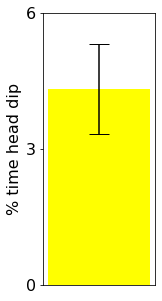

In [5]:
plt.figure(figsize=(2, 5))
pt = d['percenttime_headdip']*100
plt.bar(0, np.mean(pt), color='yellow')
plt.errorbar(0, np.mean(pt), sem(pt), fmt='k_', ms=0, capsize=10)
plt.ylabel('% time head dip')
plt.yticks([0, 3, 6])
plt.ylim(0, 6)
plt.xticks([])

plt.savefig('./elife_figs/1C.svg')

In [6]:
ttest_1samp(pt, 0)

Ttest_1sampResult(statistic=4.311670577536477, pvalue=0.0035158942047390034)

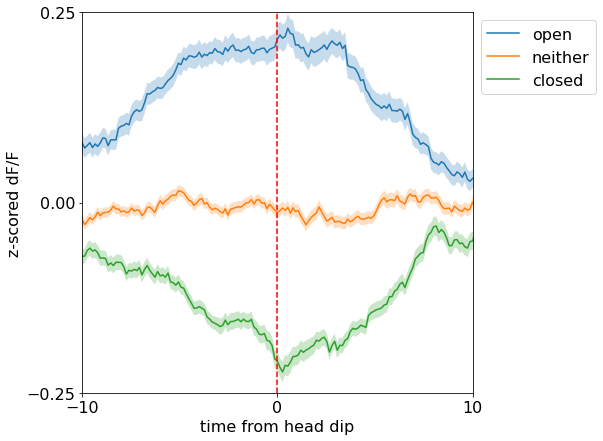

In [7]:
plt.figure(figsize=(7, 7))
t = np.arange(-timeBefore, timeAfter)/7.5
colors = ['r', 'k', 'b']
for i, typ in enumerate(['o', 'n', 'c']):
    mu = np.mean(straces[ctypes==typ], axis=0)
    err = sem(straces[ctypes==typ], axis=0)
    plt.plot(t, mu)
plt.legend(['open', 'neither', 'closed'], bbox_to_anchor=(1, 1))
for i, typ in enumerate(['o', 'n', 'c']):
    mu = np.mean(straces[ctypes==typ], axis=0)
    err = sem(straces[ctypes==typ], axis=0)
    plt.fill_between(t, mu-err, mu+err, alpha=0.25)
plt.xlabel('time from head dip')
plt.ylabel('z-scored dF/F')
plt.xlim(-10, 10)
plt.xticks([-10, 0, 10])
plt.ylim(-0.25, 0.25)
plt.yticks([-0.25, 0, 0.25])
plt.plot([0, 0], plt.ylim(), 'r--')

plt.savefig('./elife_figs/2Cl.svg')

In [8]:
t[42], t[61], t[80], t[99]

(-5.066666666666666, -2.533333333333333, 0.0, 2.533333333333333)

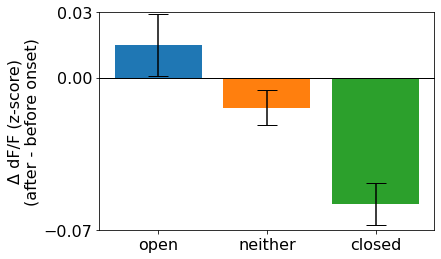

In [9]:
diffs = []
for i, typ in enumerate(['o', 'n', 'c']):
    diff = np.mean(straces[ctypes==typ][:, 80:99], axis=1) - np.mean(straces[ctypes==typ][:, 42:61], axis=1)
    diffs.append(diff)
    plt.bar(i, np.mean(diff))
    plt.errorbar(i, np.mean(diff), sem(diff), fmt='k_', ms=0, capsize=10)
plt.plot(0, 0, 'k_', ms=2000)
plt.xticks([0, 1, 2], ['open', 'neither', 'closed'])
plt.yticks([-0.07, 0, 0.03])
plt.ylim(-0.07, 0.03)
plt.ylabel('Δ dF/F (z-score)\n(after - before onset)')

plt.savefig('./elife_figs/2Cr.svg')

In [10]:
ranksums(diffs[0], diffs[2])

RanksumsResult(statistic=4.5338048674071105, pvalue=5.7930550737272765e-06)